In [30]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import powerlaw # https://pypi.org/project/powerlaw/
import random

# Analisando Dados dos Relacionamentos no GitHub

### Gabriel Pereira de Oliveira - Bacharelado em Ciência da Computação - DCC/UFMG

Com a expansão da Internet e o acesso a serviços de banda larga, pessoas comuns têm à disposição uma gama de aplicativos e serviços online. Assim, **grandes volumes de dados são gerados diariamente**, podendo ser processados com os mais variados propósitos. Entre tantas opções, sem dúvidas um dos serviços mais populares é o de **redes sociais online**, que reunem milhões de pessoas com objetivos semelhantes ao redor do mundo. 

Tais redes não são apenas para diversão e conexões pessoais, mas também para **trabalho e conexões profissionais**. Por exemplo, o **[GitHub](http://github.com)** é uma das maiores plataformas online de desenvolvimento colaborativo de software do mundo, reunindo uma comunidade de mais de **28 milhões de desenvolvedores** reunidos em mais de **85 milhões de projetos em 337 linguagens de programação** (Junho de 2018). Dessa forma, devido ao grande volume de dados, técnicas de ciência de dados são muito importantes para trazer à tona informações e análises relevantes sobre a colaboração de software no GitHub, que inicialmente não poderiam ser percebidas olhando apenas para os dados puros.

![GitHub Logo](images/github_logo.png)

Neste trabalho, será explorada a criação da rede de colaboração entre usuários no GitHub, através de diversas técnicas de ciência dos dados.

## Base de Dados

Para construir as redes de colaboração utilizadas neste trabalho, foi utilizada a base de dados que se encontra no projeto [GHTorrent](http://ghtorrent.org/). O GHTorrent é um serviço de coleta de dados públicos do GitHub que tem por objetivo facilitar o acesso aos dados oferecidos pela API oficial por desenvolvedores e pesquisadores. Em linhas gerais, esse serviço monitora os eventos lançados pela API oficial, coleta informações adicionais necessárias e os disponibiliza diretamente (i.e., no mesmo formato recebido pela API) ou de forma estruturada (i.e., em um banco de dados relacional). Com isso, temos acesso a informações de usuários, repositórios e suas atividades dentro do GitHub, como *commits* e *pull requests*. 

Os dados são oferecidos no formato .csv e a cada mês uma nova base é disponibilizada pelo GHTorrent. Para o trabalho em questão foi utilizada a base de 01/05/2017 (que reúne os dados públicos do GitHub até essa data) e ela encontra-se modelada como um banco de dados relacional MySQL. Portanto, cada arquivo CSV corresponde a uma tabela do banco de dados. O esquema completo do banco pode ser conferido na página de documentação do projeto, disponibilizada [aqui](http://ghtorrent.org/files/schema.pdf).

## Rede Social de Colaboração

A partir dos dados coletados da base do GHTorrent, podemos construir a rede social de colaboração do GitHub como um grafo  $\mathcal{G = (V,E)}$, onde $\mathcal{V}$ é o conjunto de nós que representam os desenvolvedores e $\mathcal{E}$ é o conjunto de arestas não-direcionadas que lhes conectam quando ambos colaboram em um mesmo repositório [(Alves et al. 2016)](https://homepages.dcc.ufmg.br/~mirella/pdf/2016.SBBDshort.Alves.pdf).

Além disso, [Batista et al. 2017](https://homepages.dcc.ufmg.br/~mirella/pdf/2017.SBBDshort.Batista.pdf) demonstram que é importante considerar o aspecto temporal em tal modelagem. Portanto, os relacionamentos (arestas) entre desenvolvedores existem apenas se ambos trabalham juntos durante um mesmo intervalo de tempo. A figura abaixo apresenta um exemplo de como a colaboração entre seis desenvolvedores no GitHub é modelada em uma rede de colaboração. O peso dessas arestas pode ser calculado por métricas topológicas (relacionadas à estrutura da rede) ou semânticas (referentes às propriedades específicas do GitHub).

<img src="images/GitHub_Homogeneous_SN.png" alt="SN" width="800"/>

## Linguagens de Programação

Neste projeto, vamos efetuar uma análise das redes de colaboração de **sete** linguagens de programação no GitHub. Tais linguagens foram escolhidas por serem de alta popularidade segundo o [TIOBE Index](https://www.tiobe.com/tiobe-index/) de março de 2016 e classificadas segundo seu nível de colaboração [(Rocha et al. 2016)](https://homepages.dcc.ufmg.br/~mirella/pdf/2016.SBBDshort.Rocha.pdf). As linguagens escolhidas são as seguintes:

* **Linguagens mais colaborativas** 
 * JavaScript (JS)
 * Python (PY)
 * Ruby (RB)
 
* **Linguagens menos colaborativas** 
 * Assembly (AS)
 * Pascal (PA)
 * Perl (PL)
 * Visual Basic (VB)

Para cada uma das linguagens, foi gerado o respectivo grafo de colaboração, que pode ser baixado [aqui](https://drive.google.com/drive/folders/1lcb2yFkLG80-uLQIAcEt26rVPgqGvjVy?usp=sharing). Aqui, vamos trabalhar com o grafo não-ponderado, ou seja, as arestas não possuem peso. No entanto, o peso das arestas pode ser facilmente adicionado posteriormente.

In [31]:
languages = {
    "AS": "Assembly",
    "JS": "JavaScript",
    "PA": "Pascal",
    "PL": "Perl",
    "PY": "Python",
    #"RB": "Ruby",
    "VB": "Visual Basic"
}

def generate_network(language):
    G = nx.read_edgelist('data/%s_topological_network.csv' % language, delimiter=',')
    return G

## Métricas para Análise da Rede Social

Inicialmente, para cada linguagem de programação, vamos calcular algumas métricas básicas de redes complexas para indicar algumas propriedades das redes existentes. O pacote `networkx` do Python nos ajudará bastante no cálculo das métricas e nas análises a serem feitas. As primeiras propriedades que vamos calcular são as seguintes:

### Número de Nós
É ó número de vértices existentes no grafo. No contexto da rede de colaboração do GitHub, representa o número de desenvolvedores que colaboram em cada linguagem.

### Número de Arestas
É ó número de arestas não-direcionadas existentes entre os nós no grafo. Aqui, pode representar o número de pares de desenvolvedores que colaboram entre si em cada linguagem de programação.

### Densidade
É a razão entre a quantidade de arestas do grafo e a quantidade de arestas do grafo completo (onde todos os nós têm arestas entre si) com a mesma quantidade de vértices.

### Grau médio
É a média dos graus dos vértices do grafo. O grau de um vértice em um grafo não-direcionado e não-ponderado (como é o caso das redes com as quais estamos trabalhando) é a quantidade de arestas incidentes a este vértice.

### Coeficiente de Clusterização Médio
Este coeficiente mede o grau com que os nós de um grafo tendem a agrupar-se. Para cada nó $i$ de um grafo, seu coeficiente de clusterização é dado por:

$$CC_i = \frac{2L_i}{k_i(k_1 - 1)}$$

$L_i$ representa o número de arestas entre os $k_i$ vizinhos de $i$. Um exemplo de cálculo do coeficiente de clusterização pode ser observado na figura abaixo.

<img src="images/clustering_coefficient.png" alt="CC" width="450"/>

Dessa forma, podemos calcular o CC médio para todo o grafo através da fórmula

$$CC = \frac{1}{n}\sum_{i \in G} CC_i$$

### Tamanho do Componente Gigante

O componente gigante (*giant component*) é o maior componente conectado de um grafo. Pode ser entendido como o núcleo ou o centro da rede. Em nossas análises, vamos comparar o tamanho do componente gigante com a rede completa.

## Resultados

In [32]:
def network_metrics(G):
    nodes = nx.number_of_nodes(G)
    edges = nx.number_of_edges(G)
    density = nx.density(G)
    avg_cc = nx.average_clustering(G)
    
    num_nodes = 0
    sum_degree = 0
    for i in nx.degree(G):
        num_nodes += 1
        sum_degree += i[1]
    
    avg_node_degree = (sum_degree/num_nodes)
    
    giant = max(nx.connected_component_subgraphs(G), key=len)
    giant_size = 100 * (nx.number_of_edges(giant) / edges)
    giant.clear()
    
    return [nodes, edges, density, avg_cc, avg_node_degree, giant_size]

In [33]:
metrics = {}
for language in languages:
    print("Reading %s network..." % languages[language])
    G = generate_network(language)
    metrics[language] = network_metrics(G)    
    G.clear()

metrics["RB"] = [279281, 33979590, 0.000871, 0.429, 243.34, 99.7] # Ja tinha rodado esses resultados antes, mas demorou muito para rodar novamente na versao final

Reading Assembly network...
Reading JavaScript network...
Reading Pascal network...
Reading Perl network...
Reading Python network...
Reading Visual Basic network...


As análises aqui serão feitas para cada uma das métricas calculadas, comparando as linguagens entre si. É importante sempre ter em mente a classificação das linguagens entre mais e menos colaborativas, pois isso facilitará o entendimento.

Em primeiro lugar, vamos analisar a quantidade de desenvolvedores (nós) em cada linguagem:

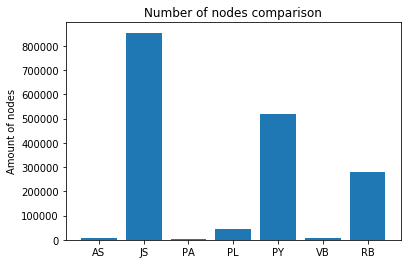

In [34]:
language_nodes = [metrics[language][0] for language in metrics]

plt.bar(metrics.keys(), language_nodes)
plt.ylabel('Amount of nodes')
plt.title("Number of nodes comparison")
plt.savefig("plots/number_of_nodes.png")

Ao comparar o número de nós em cada rede, já podemos perceber observar alguns fatos importantes. Em primeiro lugar, algumas linguagens possuem muitos desenvolvedores/usuários/nós em suas redes (JavaScript, Python e Ruby), enquanto outras possuem menos (Visual Basic, Perl e Assembly). Por exemplo, JavaScript (a linguagem com mais desenvolvedores) possui mais de 800 mil nós em sua rede, mais de dez vezes mais do que a rede de Assembly. Observe aqui que JavaScript, Python e Ruby são linguagens bastante populares atualmente, além de terem sido classificadas como mais colaborativas.

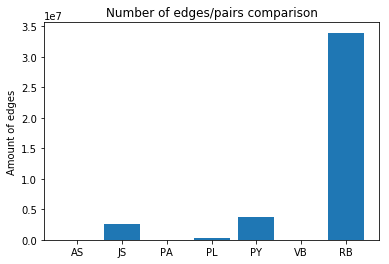

In [35]:
language_edges = [metrics[language][1] for language in metrics]

plt.bar(metrics.keys(), language_edges)
plt.ylabel('Amount of edges')
plt.title("Number of edges/pairs comparison")
plt.savefig("plots/number_of_edges.png")

Analisando o número de pares em cada rede, vemos um gráfico semelhante ao que visualiza a quantidade de nós, com as linguagens mais colaborativas tendo um número muito maior de pares do que as linguagens menos colaborativas. No entanto, a rede de Ruby, que era a terceira com mais nós (~250 mil), é a rede que mais possui pares de desenvolvedores, com quase 34 milhões de pares. Enquanto isso, JavaScript, a linguagem com maior número de usuários (~800 mil), possui somente 2,5 milhões de pares em sua rede. Por isso, podemos imaginar que pessoas que desenvolvem em Ruby colaboram muito mais entre si do que os desenvolvedores de outras linguagens.

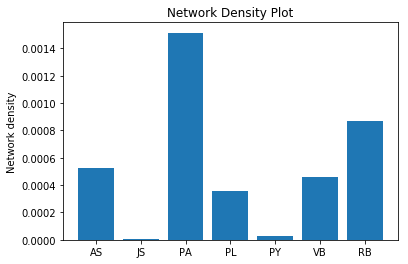

In [36]:
language_density = [metrics[language][2] for language in metrics]

plt.bar(metrics.keys(), language_density)
plt.ylabel('Network density')
plt.title("Network Density Plot")
plt.savefig("plots/density.png")

Aqui, podemos observar que a rede mais densa é a de Pascal, embora a densidade das outras linguagens não seja tão menor. No geral, todas elas possuem uma densidade bem baixa, com valores entre 0,0001 e 0,001. Por isso, pode-se afirmar que as redes do GitHub são no geral, mais esparsas.

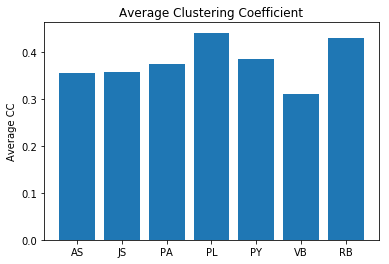

In [37]:
language_avg_cc = [metrics[language][3] for language in metrics]

plt.bar(metrics.keys(), language_avg_cc)
plt.ylabel('Average CC')
plt.title("Average Clustering Coefficient")
plt.savefig("plots/agv_cc.png")

Analisando o Coeficiente de Clusterização Médio, podemos observar que todas as linguagens têm valores para essa métrica bem próximos, variando entre 0,3 e 0,5. Por isso, pode-se dizer que os nós dessas redes não têm tanta tendência a se agruparem. O baixo valor da densidade também corrobora essa afirmação.

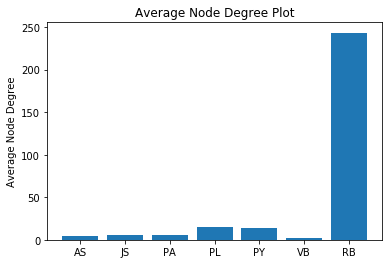

In [38]:
language_avg_degree = [metrics[language][4] for language in metrics]

plt.bar(metrics.keys(), language_avg_degree)
plt.ylabel('Average Node Degree')
plt.title("Average Node Degree Plot")
plt.savefig("plots/avg_degree.png")

Aqui novamente vemos uma forte distinção entre as linguagens mais e menos colaborativas. A rede de Ruby possui um grau médio de 243, enquanto as outras linguagens possuem um número bem menor para essa métrica. Assim, a tese de que Ruby é a mais colaborativa das linguagens ganha força, corroborada por outros resultados já vistos e também a serem vistos.

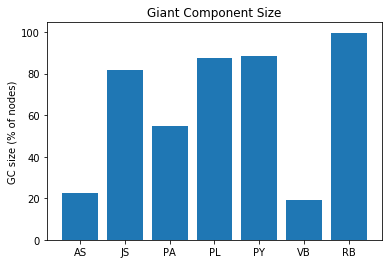

In [39]:
language_gc_size = [metrics[language][5] for language in metrics]

plt.bar(metrics.keys(), language_gc_size)
plt.ylabel('GC size (% of nodes)')
plt.title("Giant Component Size")
plt.savefig("plots/avg_cc.png")

A última métrica a ser analisada é o tamanho do componente gigante (GC) de cada rede em relação ao número de nós da rede completa. Essa métrica é a que mais evidencia o nível de colaboração das linguagens que serviu de base para a construção das redes. Todas as linguagens mais colaborativas possuem seu componente gigante com tamanho superior a 80% da rede original. Isso significa que a grande maioria dos desenvolvedores dessas linguagens estão dentro de um mesmo componente da rede, evidenciando que estão ligados de alguma forma, mesmo que indiretamente. Nas linguagens menos colaborativas, isso não se observa, já que seus GCs não chegam a representar 50% da rede.  

### Análise da distribuição de graus

A distribuição de grau dos nós da rede nos ajuda a compreender bem o seu comportamento. Para isso, vamos plotar a distibuição nas redes em duas escalas: a escala normal e a escala logaritmica, que nos auxiliará nas análises.

Muitas redes sociais seguem a distribuição **power law**, que rege as redes "livres de escala" ou *scale free*. Em tais redes, existem muitos nós com um grau pequeno e poucos nós com um grau alto. A distribuição power law é representada matematicamente pela fórmula:

$$p(k) = Ck^{-\alpha}$$

Para fazer a regressão da nossa curva de distribuição de graus, vamos utilizar o pacote `powerlaw` do [PyPI](https://pypi.org/project/powerlaw/).

In [40]:
constants = {"VB": 1000, "PA": 1800, "AS": 2500, "PL": 16000, "JS": 300000, "PY": 300000}
#constants = {"VB": 1000, "PA": 1800, "AS": 2500}

def get_degree_distribution(language):
    G = generate_network(language)
    
    degs = {}
    for n in G.nodes():
        deg = G.degree(n)
        if deg not in degs:
            degs[deg] = 0
        degs[deg] += 1

    G.clear()
    return degs



def plot_degree_distribution(language, degs, consts):
    items = sorted(degs.items())
    X = np.array([k for (k, v) in items])
    Y = np.array([v for (k, v) in items])
    
    fig = plt.figure()
    fig.suptitle("%s Network Degree Distribution" % language)
    
    ax = plt.subplot(1, 2, 1)
    ax.plot(X, Y)
    ax.set_xlabel('Node degree')
    ax.set_ylabel('Amount of nodes')
    
    max_degree = max(degs.keys(), key=int)
    num_nodes = [] 

    for i in range(1, max_degree + 1):
        num_nodes.append(degs.get(i, 0))

    np.seterr(divide='ignore', invalid='ignore') # Avoid division error
    fit = powerlaw.Fit(num_nodes, discrete=True) # power-law distribution -> p(k) = Ck^(-alpha)
    alpha = fit.power_law.alpha

    ax = plt.subplot(1, 2, 2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Node degree (log)')
    ax.set_ylabel('Amount of nodes (log)')
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")

    pl = lambda x: consts[language] * (x**(-alpha))
    ax.plot(X, Y, 'o')
    ax.plot(X, pl(X), 'r--') # plot power-law fit

    fig.savefig("plots/%s_degree_distribution.png" % language)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


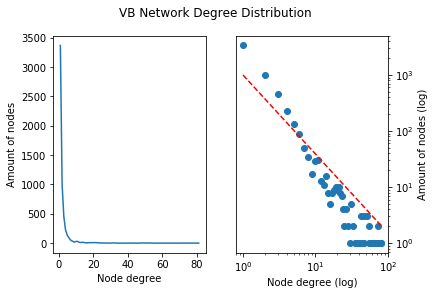

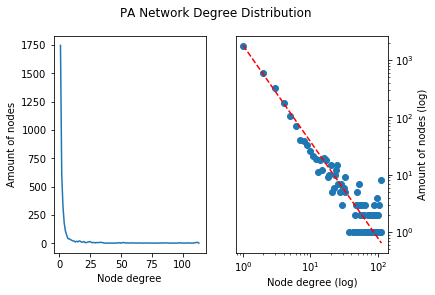

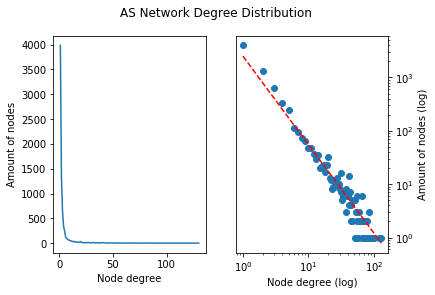

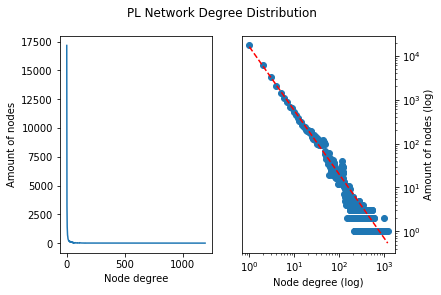

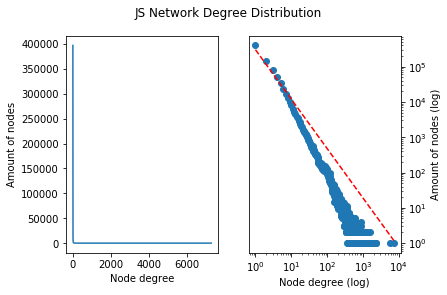

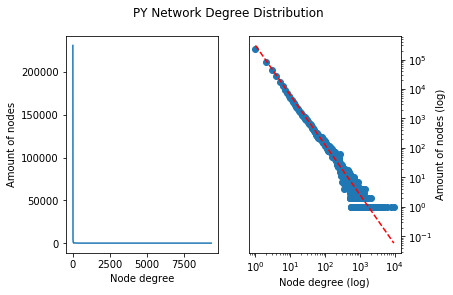

In [41]:
for language in constants:
    degs = get_degree_distribution(language)
    plot_degree_distribution(language, degs, constants)
    degs.clear()

Analisando as distribuições de graus de todas as redes, podemos dizer que todas elas se assemelham às redes *power law*, apesar de existirem alguns pontos que saem um pouco do formato desejado (*outliers*). Mesmo assim, é possível aproximar o valor do coeficiente alpha ($\alpha$) das curvas Power Law que se aproximariam da distribuição real dos graus das rede. Com a ajuda do pacote `powerlaw` do Python, foi possível chegar aos valores de $1,45 < \alpha < 1,69$. Na maioria das redes *scale-free*, tem-se $2 < \alpha < 3$. Dessa forma, é possível dizer que as redes analisadas são bem semelhantes à maioria das redes *scale-free*.

## Mas e a rede de Ruby?

Com redes grandes, como a rede de colaboração de Ruby, não conseguimos rodas as análises de distribuição de grau e outras demoram muito tempo para serem executadas, devido a **restrições de processamento e principalmente de memória**.

Dessa forma, uma abordagem para se resolver este problema é efetuar uma **amostragem** (*sampling*) da rede, extraindo uma pequena parte dos nós e arestas para efetuar os cálculos e análises desejadas. Entretanto, precisamos manter a aleatoriedade e evitar o enviesamento ao amostrar a rede.

Por isso, escolhemos aplicar o algoritmo **Metropolis-Hastings Random Walk (MHRW)** no nosso grafo, que efetua um caminhamento aleatório (como o próprio nome ja diz) e também utiliza de conceitos de probabilidade para efetuar a amostragem. 

A implementação do MHRW foi adaptada do pacote `Graph-Sampling`, por Ashish7129, disponível [aqui](https://github.com/Ashish7129/Graph-Sampling).

In [42]:
class MHRW():
    def __init__(self):
        self.G1 = nx.Graph()
        
    def mhrw(self,G,node,size):
        dictt = {}
        node_list = set()
        node_list.add(node)
        parent_node = node_list.pop()
        dictt[parent_node] = parent_node
        degree_p = G.degree(parent_node)
        related_list = list(G.neighbors(parent_node))
        node_list.update(related_list)

        while(len(self.G1.nodes()) < size):
            if(len(node_list) > 0):
                child_node = node_list.pop()
                p =  round(random.uniform(0,1),4)
                if(child_node not in dictt):
                    related_listt = list(G.neighbors(child_node))
                    degree_c = G.degree(child_node)
                    dictt[child_node] = child_node
                    if(p <= min(1,degree_p/degree_c) and child_node in list(G.neighbors(parent_node))):
                        self.G1.add_edge(parent_node,child_node)
                        parent_node = child_node
                        degree_p = degree_c
                        node_list.clear()
                        node_list.update(related_listt)
                    else:
                        del dictt[child_node]

            # node_list set becomes empty or size is not reached 
            # insert some random nodes into the set for next processing
            else:
                node_list.update(random.sample(set(G.nodes())-set(self.G1.nodes()),3))
                parent_node = node_list.pop()
                G.add_node(parent_node)
                related_list = list(G.neighbors(parent_node))
                node_list.clear()
                node_list.update(related_list)
        return self.G1

In [43]:
language = "AS"
G = generate_network(language)

nodes = nx.number_of_nodes(G)
size = int(nodes * 0.5) # sample will have only 50% of the nodes 
random_node = random.choice(list(G.nodes))

print("Executing MHRW...")
sample = MHRW()
sample.mhrw(G, random_node, size)

print("Writing sample network...")
nx.write_edgelist(sample.G1, "sampling/%s_sample_network_50.csv" % language, delimiter=",", data=False)

G.clear()

print("Nodes:", nx.number_of_nodes(sample.G1))
print("Edges:", nx.number_of_edges(sample.G1))
print("Density:", nx.density(sample.G1))

Executing MHRW...
Writing sample network...
Nodes: 3759
Edges: 2675
Density: 0.0003787256159104967


Infelizmente, a execução deste algoritmo para redes grandes leva um bom tempo. Para a realização deste trabalho, não foi possível obter os resultados desejados para a rede de Ruby. No entanto, ao executar para redes menores, pôde-se perceber que **o número de arestas na amostra diminuiu consideravelmente**, apesar de ainda mantermos 50% dos nós na rede. Por isso, é necessário pensar uma estratégia melhor de amostragem de rede para o contexto do GitHub, visto que os pares de desenvolvedores (arestas) são o nosso principal objeto de interesse.

## Conclusão

Este trabalho realizou uma análise exploratória sobre as redes de colaboração de diferentes linguagens de programação no GitHub. Dentre as principais descobertas, pode-se citar a confirmação do nível de colaboração de cada linguagem e também o fato de a distribuição de graus das redes se aproximar bastante de uma curva *power law*. O principal desafio aqui foi realizar a amostragem da rede, que infelizmente não foi concluída totalmente. Apesar disso, pode-se dizer que o trabalho foi proveitoso e bem-sucedido, principalmente pelo aprendizado e aplicação das técnicas de ciência dos dados.